# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )


# ICR - Identifying Age-Related Conditions Dataset with TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the ICR - Identifying Age-Related Conditions dataset made available for this competition. The goal of the model is to predict if a person has one or more of any of three medical conditions or none.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

# Import the libraries

In [14]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer

# new
from tqdm.notebook import tqdm

In [15]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.12.0
TensorFlow Decision Forests v1.3.0


# Load the Dataset

In [16]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


The data is composed of 58 columns and 617 entries. We can see all 58 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [17]:
dataset_df.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


`Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`).
Given the features of the dataset, the goal of our model is to predict the value of `Class` for any person.

# Quick basic dataset exploration

In [18]:
dataset_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


## Pie chart for label column: Class

<Axes: ylabel='Class'>

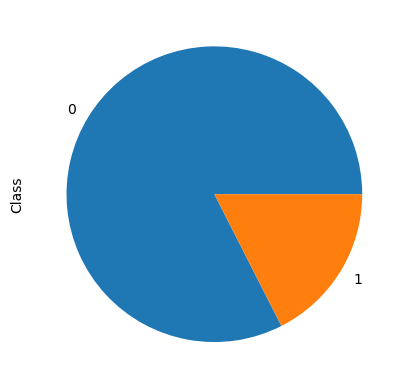

In [19]:
plot_df = dataset_df.Class.value_counts()
plot_df.plot(kind="pie")

**Important**: From the pie chart we can see that the dataset is heavily imbalanced since the fraction of positive(`1`) samples is very small compared to the negative(`0`) samples.

# Numerical data distribution

First, we will list all the numerical columns names.

We will also create a list of feature columns that will be used for training. We will drop `Id` from the list since it is not needed.

In [20]:
FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id","Class"]]

In [21]:
dataset_df[['EJ','DU','EH','FD ','FL','GL']].value_counts()

EJ  DU          EH         FD           FL          GL       
A   0.005518    0.003042   0.296850     0.173229    21.978000    222
B   0.006897    0.024336   0.296850     0.296625    2.376000       4
    0.055176    0.012168   1.139904     6.443383    0.148500       3
    0.006897    0.006084   1.027101     4.105290    0.594000       2
    1.338018    0.091260   1.502061     5.574782    0.045928       1
                                                                ... 
    0.482790    0.006084   1.763289     58.966209   0.008486       1
    0.462099    0.097344   2.119509     4.333945    0.141851       1
    0.448305    0.152100   2.172942     2.800886    0.228462       1
                0.127764   3.004122     4.609838    0.191908       1
    161.355315  42.569748  1578.654237  137.932739  0.177654       1
Length: 389, dtype: int64

Now let us split the dataset into training and testing datasets:

# Feature Engineering

## Filter Monotonic Features

In [22]:
def compute_basic_stats(columns, df):
    out = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

basic_stats_1 = compute_basic_stats(columns=FEATURE_COLUMNS, df=dataset_df)

basic_stats_1

  0%|          | 0/56 [00:00<?, ?it/s]

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU,253,0.2,float64,0.26,0.005518,161.355315,9.034721,1.8029,5.55868
BC,259,0.0,float64,0.16,1.2299,1463.693448,65.166943,8.053012,5.724924
AF,599,0.0,float64,0.3,192.59328,28688.18766,2300.322717,3502.013221,5.900177
EH,127,0.0,float64,0.18,0.003042,42.569748,1.847499,0.305107,5.900177
AM,605,0.0,float64,0.24,3.177522,630.51823,69.728226,38.968552,5.900177
FD,337,0.0,float64,0.13,0.29685,1578.654237,64.754262,6.930086,5.900177
DI,571,0.0,float64,0.26,60.23247,1049.168078,86.084419,146.972099,5.900177
FR,435,0.0,float64,0.1,0.49706,1244.22702,50.181948,3.533905,5.900177
AB,217,0.0,float64,0.28,0.081187,6.161666,0.468388,0.477149,6.017012
CF,586,0.0,float64,0.11,0.510888,200.967526,13.571133,11.241064,6.192265


* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


## Normalise Features

In [24]:
def preprocess_1(train: pd.DataFrame, test: pd.DataFrame, stats: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, dict):
    info = dict()
    stats_features = stats[stats.logloss.notna()].index
    train_out = train.copy()
    test_out = test.copy()
    for i in stats_features:
        if i != 'EJ':

            if stats.loc[i,'correlation'] > 0:
                na_value = stats.loc[i,'max']
            else:
                na_value = stats.loc[i,'min']
                
            train_out[i] = train_out[i].fillna(na_value)
            test_out[i] = test_out[i].fillna(na_value)
            
            train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
            test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
            
    return train_out,test_out


train_out_1,test_out_1 = preprocess_1(train=dataset_df, test=dataset_test_df, stats=basic_stats_1)

# KFold validation

We will use KFold cross validation for training this model since the normal train/test split training won't be enough to acheive decent score.

We will split the dataset into 5 consecutive folds. Each fold is then used once as a validation set while the 4 (5-1) remaining folds form the training set.

Read more about KFold [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [25]:
from sklearn.model_selection import StratifiedKFold, KFold
# skf = StratifiedKFold(n_splits=8)
# X,y = dataset_df_normalised.values.copy(),dataset_df['Class'].values.reshape(-1,1).copy()
# for train, test in skf.split(X=X, y=y):
#     print(f'train -  {y[train].sum()/len(y[train])}   |   test -  {y[train].sum()/len(y[train])}')

# Out of Fold (OOF)

During KFold cross validation, the predictions made on the test set of each fold is known as Out of Fold(OOF) predictions. We will estimate the performance of the model using the predictions made across all the k (5 in this example) folds.

For our training loop, we will create a pandas dataframe named `oof` to store the predictions of the validation set during each fold.

In [28]:
# # Added to train step
# # Create list of ids for the creation of oof dataframe.
# ID_LIST = dataset_df.index

# # Create a dataframe of required size with zero values.
# oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# # Create an empty dictionary to store the models trained for each fold.
# models = {}

# # Create empty dict to save metircs for the models trained for each fold.
# accuracy = {}
# cross_entropy = {}

# # Save the name of the label column to a variable.
# label = "Class"

# Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [29]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

# How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get a better score.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

# Hyperparameter tuning to avoid overfitting

Because of the smaller size of the dataset, it is likely that the model will overfit during training.
Numerous parameters, primarily `max_depth` and `num_trees` can be changed to fine-tune the model and prevent overfitting.

The attribute`max_depth` indicates the maximum depth of the tree. To avoid overfitting, we can try to reduce the depth of the tree from it's default value, which is `16`. Another way to tackle overfitting is to increase the number of individual decision trees. To do this, we have to increase the value of the parameter `num_trees` from its default value(`300`).

You can set these parameters as follows:

```rf = tfdf.keras.RandomForestModel(max_depth=5, num_trees=500)```

# Strategies to handle the dataset imbalance

Let's examine the fraction of positive and negative samples in this dataset's  by examining the`Class` column.

In [30]:
# Calculate the number of negative and positive values in `Class` column
neg, pos = np.bincount(dataset_df['Class'])
# Calculate total samples
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 617
    Positive: 108 (17.50% of total)



As we can see, positive samples only account for 17.50% of the data. This means that our datastet is heavily imbalanced.

In classification problems with imbalanced datasets, a model tends to be more biased towards the majority class leading to the model performing poorly on the samples belonging to the minority class.

There are many techniques for dealing with imbalanced data. The most suitable techniques for this dataset are:

* Undersampling
* Class weighting

In this notebook we will use **Class weighting** to deal with imbalanced data. But first, we will quickly outline how undersampling can be performed.

# Undersampling

One approach to deal with an imbalanced dataset would be to under-sample the majority class(es) by choosing a smaller subset of the majority class samples(negative or `0` class in this case) from the dataset rather than picking the entire data.

Note: You have to loop through the dataset and try different random subsets for a better score.

The code snippet below illustrates how to perform undersampling.

```
# This function generates undersampled dataset.
def random_under_sampler(df):
    # Calculate the number of samples for each label. 
    neg, pos = np.bincount(df['Class'])

    # Choose the samples with class label `1`.
    one_df = df.loc[df['Class'] == 1] 
    # Choose the samples with class label `0`.
    zero_df = df.loc[df['Class'] == 0]
    # Select `pos` number of negative samples.
    # This makes sure that we have equal number of samples for each label.
    zero_df = zero_df.sample(n=pos)

    # Join both label dataframes.
    undersampled_df = pd.concat([zero_df, one_df])

    # Shuffle the data and return
    return undersampled_df.sample(frac = 1)
```

# Class weighting

Since the postive(`1`) `Class` labels are only a small fraction of the dataset, we would want the classifier to heavily weight those examples. You can do this by passing **Keras weights** for each class through a parameter. This will cause the model to "pay more attention" to examples from an under-represented class. Read more about class weights [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights).

In [31]:
# Added to Train Step
# Calculate the number of samples for each label.
neg, pos = np.bincount(dataset_df['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


To train and evaluate the models using class weights, use the dict in model.fit() as an argument as shown below.

```model.fit(x=train_ds, class_weight=class_weight)```

# Train Random Forest Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [66]:
def train_model(train: pd.DataFrame, test: pd.DataFrame, stats: pd.DataFrame,
                n_splits: int = 6, 
                model_obj = tfdf.keras.RandomForestModel, 
                model_kwargs = dict(),
                model_compile_kwargs = dict()) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, dict):
    
    # Create list of ids for the creation of oof dataframe.
    ID_LIST = train.index

    # Create a dataframe of required size with zero values.
    oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)
    
    submition = pd.DataFrame(data=np.zeros((len(test.index),n_splits)),index=test.index)

    # Create an empty dictionary to store the models trained for each fold.
    models = {}

    # Create empty dict to save metircs for the models trained for each fold.
    accuracy = {}
    cross_entropy = {}

    # Save the name of the label column to a variable.
    label = "Class"
    
    
    # Calculate the number of samples for each label.
    neg, pos = np.bincount(train[label])

    # Calculate total samples.
    total = neg + pos

    # Calculate the weight for each label.
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    # Names of columns
    cols_features = stats[stats.logloss.notna()].index.tolist()
    # Loop through each fold
    
    skf = StratifiedKFold(n_splits=n_splits)
    
    submition_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[cols_features+[label]]
            valid_df = valid_df[cols_features+[label]]

            # There's one more step required before we can train the model. 
            # We need to convert the datatset from Pandas format (pd.DataFrame)
            # into TensorFlow Datasets format (tf.data.Dataset).
            # TensorFlow Datasets is a high performance data loading library 
            # which is helpful when training neural networks with accelerators like GPUs and TPUs.
            # Note: Some column names contains white spaces at the end of their name, 
            # which is non-comaptible with SavedModels save format. 
            # By default, `pd_dataframe_to_tf_dataset` function will convert 
            # this column names into a compatible format. 
            # So you can safely ignore the warnings related to this.
            train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
            valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

            # Define the model and metrics
            #tfdf.keras.RandomForestModel(max_depth=5, num_trees=500)
            #tfdf.keras.GradientBoostedTreesModel()
            
            model = model_obj(**model_kwargs)
            
            model.compile(**model_compile_kwargs) 

            # Train the model
            # We will train the model using a one-liner.
            # Note: you may see a warning about Autograph. 
            # You can safely ignore this, it will be fixed in the next release.
            # Previously calculated class weights is used to handle imbalance.
            model.fit(x=train_ds, class_weight=class_weight)

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict OOF value for validation data
            predict = model.predict(x=valid_ds)

            # Store the predictions in oof dataframe
            oof.loc[valid_ids, 0] = predict.flatten() 
            
            # Predict Submition values
            # Store the predictions in oof dataframe
            submition.loc[:, i] = model.predict(x=submition_ds).flatten() 

            # Evaluate and store the metrics in respective dicts
            evaluation = model.evaluate(x=valid_ds,return_dict=True)
            accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
            cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]
            
    return submition,models,accuracy,cross_entropy


def print_average_accuracy(models,cross_entropy,accuracy):
    average_loss = 0
    average_acc = 0

    for _model in  models:
        average_loss += cross_entropy[_model]
        average_acc += accuracy[_model]
        print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

    print(f"\nAverage accuracy: {average_acc/len(models):.4f}  Average loss: {average_loss/len(models):.4f}")

In [68]:
# RandomForestModel
# tfdf.keras.RandomForestModel(max_depth=5, num_trees=500)

submition_1, model_1,accuracy_1,cross_entropy_1  = train_model(train=train_out_1,test=test_out_1, stats=basic_stats_1,
                                                              model_obj=tfdf.keras.RandomForestModel,
                                                              model_kwargs=dict(max_depth=5, num_trees=500),
                                                              model_compile_kwargs=dict(metrics=["accuracy", "binary_crossentropy"]))

print_average_accuracy(models=model_1, cross_entropy=cross_entropy_1, accuracy=accuracy_1)

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp__4i09ai as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.925150. Found 514 examples.
Training model...
Model trained in 0:00:00.168115
Compiling model...


[INFO 23-07-08 14:45:04.0302 UTC kernel.cc:1242] Loading model from path /tmp/tmp__4i09ai/model/ with prefix d816a88598224c19
[INFO 23-07-08 14:45:04.0491 UTC decision_forest.cc:660] Model loaded with 500 root(s), 11450 node(s), and 55 input feature(s).
[INFO 23-07-08 14:45:04.0491 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 397ms/step


/tmp/ipykernel_32/2743962201.py:100: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 0s 291ms/step - loss: 0.0000e+00 - accuracy: 0.9515 - binary_crossentropy: 0.2348
##### Fold 2
Use /tmp/tmpfgg5_gu_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.869326. Found 514 examples.
Training model...
Model trained in 0:00:00.167749
Compiling model...


[INFO 23-07-08 14:45:06.4585 UTC kernel.cc:1242] Loading model from path /tmp/tmpfgg5_gu_/model/ with prefix 4d83811029774bca
[INFO 23-07-08 14:45:06.4771 UTC decision_forest.cc:660] Model loaded with 500 root(s), 11516 node(s), and 55 input feature(s).
[INFO 23-07-08 14:45:06.4771 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 379ms/step


/tmp/ipykernel_32/2743962201.py:100: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 0s 303ms/step - loss: 0.0000e+00 - accuracy: 0.8350 - binary_crossentropy: 0.3214
##### Fold 3
Use /tmp/tmpdfsnwnww as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.841210. Found 514 examples.
Training model...
Model trained in 0:00:00.178522
Compiling model...


[INFO 23-07-08 14:45:08.8461 UTC kernel.cc:1242] Loading model from path /tmp/tmpdfsnwnww/model/ with prefix 20b1f9ebaa43463b
[INFO 23-07-08 14:45:08.8667 UTC decision_forest.cc:660] Model loaded with 500 root(s), 11570 node(s), and 55 input feature(s).
[INFO 23-07-08 14:45:08.8667 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 548ms/step


/tmp/ipykernel_32/2743962201.py:100: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 0s 367ms/step - loss: 0.0000e+00 - accuracy: 0.9320 - binary_crossentropy: 0.2678
##### Fold 4
Use /tmp/tmpfaylyu55 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.027426. Found 514 examples.
Training model...
Model trained in 0:00:00.166096
Compiling model...


[INFO 23-07-08 14:45:13.0668 UTC kernel.cc:1242] Loading model from path /tmp/tmpfaylyu55/model/ with prefix ce3dd587016d4187
[INFO 23-07-08 14:45:13.0910 UTC decision_forest.cc:660] Model loaded with 500 root(s), 11614 node(s), and 55 input feature(s).
[INFO 23-07-08 14:45:13.0910 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-08 14:45:13.0910 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 401ms/step


/tmp/ipykernel_32/2743962201.py:100: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 0s 304ms/step - loss: 0.0000e+00 - accuracy: 0.9126 - binary_crossentropy: 0.2985
##### Fold 5
Use /tmp/tmpvcseh1yx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.878451. Found 514 examples.
Training model...
Model trained in 0:00:00.178689
Compiling model...


[INFO 23-07-08 14:45:15.6132 UTC kernel.cc:1242] Loading model from path /tmp/tmpvcseh1yx/model/ with prefix a0f26fbdd4874c6f
[INFO 23-07-08 14:45:15.6360 UTC decision_forest.cc:660] Model loaded with 500 root(s), 11490 node(s), and 55 input feature(s).
[INFO 23-07-08 14:45:15.6361 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 364ms/step


/tmp/ipykernel_32/2743962201.py:100: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 0s 301ms/step - loss: 0.0000e+00 - accuracy: 0.9126 - binary_crossentropy: 0.3046
##### Fold 6
Use /tmp/tmpxwf08fr_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.829552. Found 515 examples.
Training model...
Model trained in 0:00:00.160356
Compiling model...


[INFO 23-07-08 14:45:17.9644 UTC kernel.cc:1242] Loading model from path /tmp/tmpxwf08fr_/model/ with prefix 6589112733bf4f3f
[INFO 23-07-08 14:45:17.9850 UTC decision_forest.cc:660] Model loaded with 500 root(s), 11562 node(s), and 55 input feature(s).
[INFO 23-07-08 14:45:17.9850 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 363ms/step


/tmp/ipykernel_32/2743962201.py:100: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 0s 283ms/step - loss: 0.0000e+00 - accuracy: 0.9510 - binary_crossentropy: 0.2450
fold_1: acc: 0.9515 loss: 0.2348
fold_2: acc: 0.8350 loss: 0.3214
fold_3: acc: 0.9320 loss: 0.2678
fold_4: acc: 0.9126 loss: 0.2985
fold_5: acc: 0.9126 loss: 0.3046
fold_6: acc: 0.9510 loss: 0.2450

Average accuracy: 0.9158  Average loss: 0.2787


In [73]:
# GBT
# tfdf.keras.GradientBoostedTreesModel()

submition_2, model_2,accuracy_2,cross_entropy_2  = train_model(
    train=train_out_1,test=test_out_1, stats=basic_stats_1,
                                                              
    model_obj=tfdf.keras.GradientBoostedTreesModel,
                                                              
    model_kwargs=dict(sampling_method='GOSS',max_depth=2, num_trees=1500, min_examples=4),
                                                              
    model_compile_kwargs=dict(metrics=["accuracy", "binary_crossentropy"]))

print_average_accuracy(models=model_2, cross_entropy=cross_entropy_2, accuracy=accuracy_2)

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpf126tsky as temporary training directory
Reading training dataset...


[WARNING 23-07-08 14:48:18.8004 UTC gradient_boosted_trees.cc:1783] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
[WARNING 23-07-08 14:48:18.8004 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.827760. Found 514 examples.
Training model...
Model trained in 0:00:00.428604
Compiling model...


[INFO 23-07-08 14:48:20.0640 UTC kernel.cc:1242] Loading model from path /tmp/tmpf126tsky/model/ with prefix 7c621e44ac7f4f41
[INFO 23-07-08 14:48:20.0664 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-08 14:48:20.0664 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 362ms/step


/tmp/ipykernel_32/2743962201.py:100: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 0s 280ms/step - loss: 0.0000e+00 - accuracy: 0.9223 - binary_crossentropy: 0.1870
##### Fold 2
Use /tmp/tmpbcakp_kl as temporary training directory
Reading training dataset...


[WARNING 23-07-08 14:48:21.7801 UTC gradient_boosted_trees.cc:1783] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
[WARNING 23-07-08 14:48:21.7801 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.800122. Found 514 examples.
Training model...
Model trained in 0:00:00.162665
Compiling model...


[INFO 23-07-08 14:48:22.7518 UTC kernel.cc:1242] Loading model from path /tmp/tmpbcakp_kl/model/ with prefix 9d7772ffb88a4fdb
[INFO 23-07-08 14:48:22.7530 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 356ms/step


/tmp/ipykernel_32/2743962201.py:100: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 0s 283ms/step - loss: 0.0000e+00 - accuracy: 0.8350 - binary_crossentropy: 0.3644
##### Fold 3
Use /tmp/tmp5edzbn_s as temporary training directory
Reading training dataset...


[WARNING 23-07-08 14:48:24.0531 UTC gradient_boosted_trees.cc:1783] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
[WARNING 23-07-08 14:48:24.0532 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.872544. Found 514 examples.
Training model...
Model trained in 0:00:00.199918
Compiling model...


[INFO 23-07-08 14:48:25.1325 UTC kernel.cc:1242] Loading model from path /tmp/tmp5edzbn_s/model/ with prefix 9ee60c7e719441aa
[INFO 23-07-08 14:48:25.1338 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 355ms/step


/tmp/ipykernel_32/2743962201.py:100: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 0s 280ms/step - loss: 0.0000e+00 - accuracy: 0.9320 - binary_crossentropy: 0.2465
##### Fold 4
Use /tmp/tmpjxdiu20f as temporary training directory
Reading training dataset...


[WARNING 23-07-08 14:48:26.4412 UTC gradient_boosted_trees.cc:1783] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
[WARNING 23-07-08 14:48:26.4412 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.844731. Found 514 examples.
Training model...
Model trained in 0:00:00.353229
Compiling model...


[INFO 23-07-08 14:48:27.6451 UTC kernel.cc:1242] Loading model from path /tmp/tmpjxdiu20f/model/ with prefix 1ac3e4a0bda844c4
[INFO 23-07-08 14:48:27.6482 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 361ms/step


/tmp/ipykernel_32/2743962201.py:100: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 0s 289ms/step - loss: 0.0000e+00 - accuracy: 0.8738 - binary_crossentropy: 0.3392
##### Fold 5
Use /tmp/tmps4bahy4_ as temporary training directory
Reading training dataset...


[WARNING 23-07-08 14:48:28.9698 UTC gradient_boosted_trees.cc:1783] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
[WARNING 23-07-08 14:48:28.9698 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.899024. Found 514 examples.
Training model...
Model trained in 0:00:00.168253
Compiling model...


[INFO 23-07-08 14:48:30.0450 UTC kernel.cc:1242] Loading model from path /tmp/tmps4bahy4_/model/ with prefix aa0e1486b97f4933
[INFO 23-07-08 14:48:30.0463 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 357ms/step


/tmp/ipykernel_32/2743962201.py:100: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 0.8835 - binary_crossentropy: 0.3142
##### Fold 6
Use /tmp/tmpymohfl44 as temporary training directory
Reading training dataset...


[WARNING 23-07-08 14:48:32.6108 UTC gradient_boosted_trees.cc:1783] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
[WARNING 23-07-08 14:48:32.6109 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.008197. Found 515 examples.
Training model...
Model trained in 0:00:00.109372
Compiling model...


[INFO 23-07-08 14:48:33.7374 UTC kernel.cc:1242] Loading model from path /tmp/tmpymohfl44/model/ with prefix 105b188fabd34f64
[INFO 23-07-08 14:48:33.7383 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-08 14:48:33.7383 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 367ms/step


/tmp/ipykernel_32/2743962201.py:100: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 0s 329ms/step - loss: 0.0000e+00 - accuracy: 0.8922 - binary_crossentropy: 0.3724
fold_1: acc: 0.9223 loss: 0.1870
fold_2: acc: 0.8350 loss: 0.3644
fold_3: acc: 0.9320 loss: 0.2465
fold_4: acc: 0.8738 loss: 0.3392
fold_5: acc: 0.8835 loss: 0.3142
fold_6: acc: 0.8922 loss: 0.3724

Average accuracy: 0.8898  Average loss: 0.3039


# Visualize the model
One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. We can select any tree for display.

Let us pick one model from the `models` dict and select a tree for display.

In [64]:
tfdf.model_plotter.plot_model_in_colab(model_2['fold_1'], tree_idx=20, max_depth=10)

# Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training, we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model. The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the `binary_crossentropy` evaluated on the out of bag dataset according to the number of trees in the model. Let us plot this for the models of each fold.

Note: Smaller values are better for this hyperparameter.

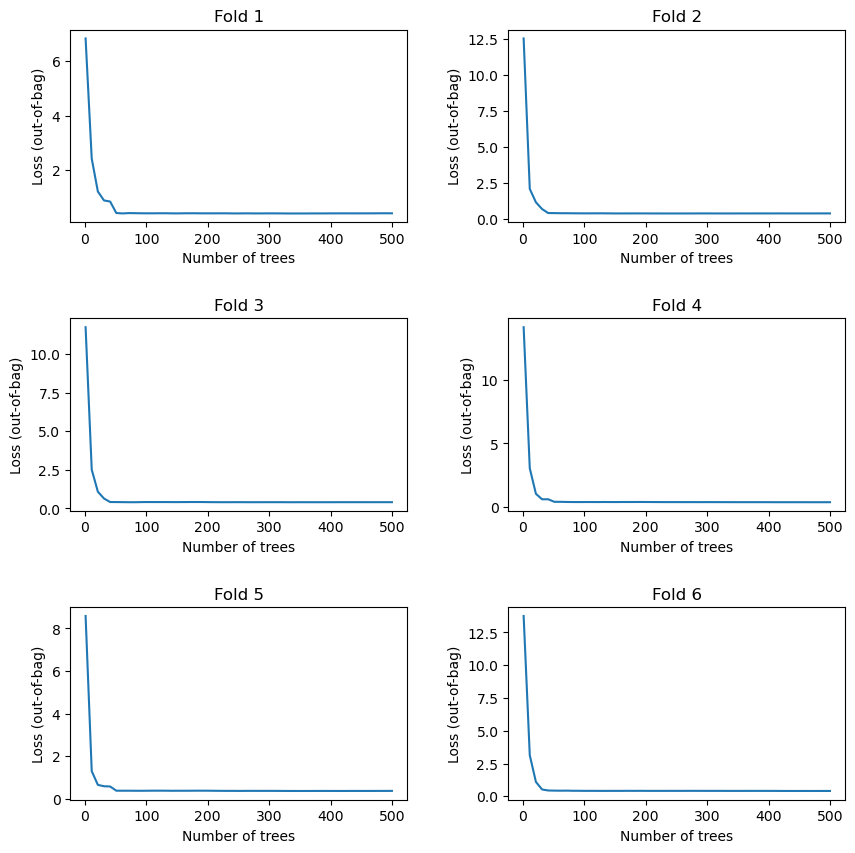

In [52]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, fold_no in enumerate(model_2.keys()):
    row = i//2
    col = i % 2
    logs = model_1[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')

# axis[2][1].set_visible(False)
plt.show()

We can also see some general stats on the OOB dataset:

In [53]:
for _model in model_1:
    inspector = model_1[_model].make_inspector()
    print(_model, inspector.evaluation())

fold_1 Evaluation(num_examples=514, accuracy=0.8459203931533753, loss=0.4132374980936038, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_2 Evaluation(num_examples=514, accuracy=0.8831357381207969, loss=0.37214773842065174, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_3 Evaluation(num_examples=514, accuracy=0.8582127013571651, loss=0.40341492732782036, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_4 Evaluation(num_examples=514, accuracy=0.8652867825840167, loss=0.38076066497595723, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_5 Evaluation(num_examples=514, accuracy=0.873703629818328, loss=0.36858526079551107, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_6 Evaluation(num_examples=515, accuracy=0.8373568839986084, loss=0.40672869003695966, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)


In [54]:
for _model in model_2:
    inspector = model_2[_model].make_inspector()
    print(_model, inspector.evaluation())

fold_1 Evaluation(num_examples=None, accuracy=0.9141502380371094, loss=0.4468897581100464, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_2 Evaluation(num_examples=None, accuracy=0.9466601014137268, loss=0.4453515112400055, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_3 Evaluation(num_examples=None, accuracy=0.8777604699134827, loss=0.6384639739990234, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_4 Evaluation(num_examples=None, accuracy=0.9147058725357056, loss=0.5809652805328369, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_5 Evaluation(num_examples=None, accuracy=0.844359815120697, loss=0.7235029339790344, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_6 Evaluation(num_examples=None, accuracy=0.8613638877868652, loss=0.7719549536705017, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)


Now, let us check the evaluation metrics for each fold and its average value.

In [47]:
print_average_accuracy(models=model_1, cross_entropy=cross_entropy_1, accuracy=accuracy_1)

print_average_accuracy(models=model_2, cross_entropy=cross_entropy_2, accuracy=accuracy_2)

fold_1: acc: 0.9515 loss: 0.2348
fold_2: acc: 0.8350 loss: 0.3214
fold_3: acc: 0.9320 loss: 0.2678
fold_4: acc: 0.9126 loss: 0.2985
fold_5: acc: 0.9126 loss: 0.3046
fold_6: acc: 0.9510 loss: 0.2450

Average accuracy: 0.9158  Average loss: 0.2787
fold_1: acc: 0.8252 loss: 0.6816
fold_2: acc: 0.1748 loss: 0.7009
fold_3: acc: 0.1748 loss: 0.7058
fold_4: acc: 0.1748 loss: 0.6961
fold_5: acc: 0.8252 loss: 0.6720
fold_6: acc: 0.8235 loss: 0.6904

Average accuracy: 0.4997  Average loss: 0.6911


# Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests. Let us pick one model from models dict and inspect it.

Let us list the available `Variable Importances` for Decision Trees:

In [ ]:
# inspector = model_1['fold_1'].make_inspector()

# print(f"Available variable importances:")
# for importance in inspector.variable_importances().keys():
#     print("\t", importance)

As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [ ]:
# Each line is: (feature name, (index of the feature), importance score)
# inspector.variable_importances()["NUM_AS_ROOT"]

# Submission

In [ ]:
def create_submitions(submition: pd.DataFrame) -> pd.DataFrame:
    
    df = pd.DataFrame(data=np.zeros((len(submition.index),2)),index=submition.index, columns=['class_0','class_1'])
    
    df['class_1'] = submition_1.mean(axis=1)
    df['class_0'] = 1 - df['class_1']
    
    return df

In [ ]:
submition_1_final = create_submitions(submition=submition_1)

In [ ]:
submition_1_final.to_csv('/kaggle/working/submission.csv', index=True)